# Pricing Options Using Quasi-Monte Carlo Sampling
Most of our Monte Carlo methods have relied on independent and
%identically distributed (IID) samples.  But we can often compute the
answer faster by using *low discrepancy* or *highly stratified* samples.
This demo shows the advantages for some of the option pricing problems
that have been studied using IID sampling.


### Different sampling strategies
We consider the problem of sampling uniformly on the unit cube, $[0,1]^d$. 
For illustration we choose $d = 2$.  Here are $n=256$ IID samples

In [1]:
# Import necessary packages
import qmcpy as qp
import numpy as np
import matplotlib.pyplot as plt
import time

/Users/yding/opt/anaconda3/envs/qmcpy/lib/python3.9/site-packages/scipy/__init__.py:155


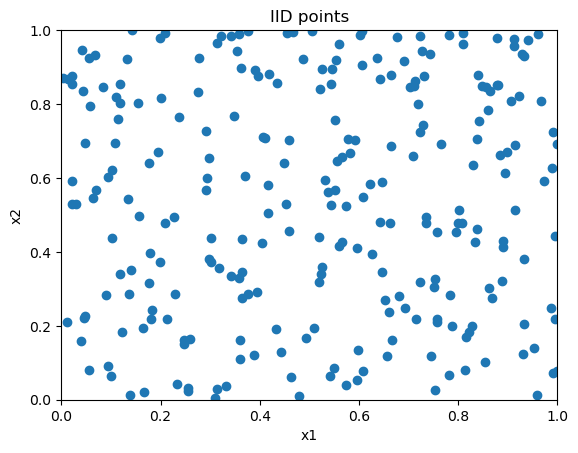

In [2]:
d = 2
n = 256
xIID = np.random.rand(n,d)
plt.scatter(xIID[:, 0], xIID[:, 1])
plt.title('IID points')
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis([0,1,0,1])
plt.show()

Since the points are IID, there are gaps and clusters.  The points do not know about the locations of each other.

### Shifted lattice node sets
One set of more _evenly_ distributed points are node sets of _integration lattices_.  They look like a tilted grid. Here is an example with a shift
modulo one.

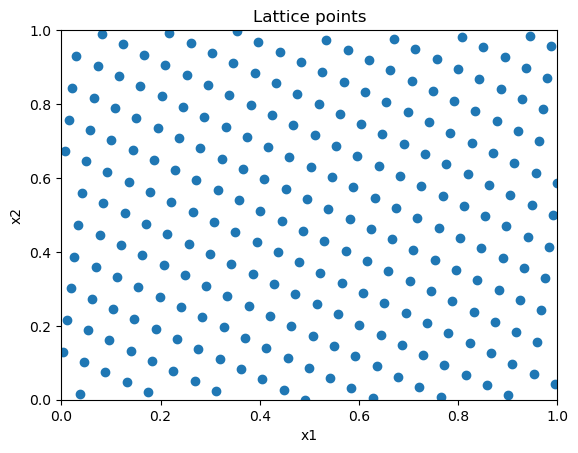

In [3]:
xLattice = qp.Lattice(d).gen_samples(n)
plt.scatter(xLattice[:, 0], xLattice[:, 1])
plt.title('Lattice points')
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis([0,1,0,1])
plt.show()

Now the gaps are smaller and the clusters are less dense.  The points _do_ know about the locations of each other, so they are _dependent_.

### Scrambled Sobol' points
Another way to sample more _evenly_ is to use Sobol' points.  Here is a
plot of the same number of Sobol' points. They are also random, but not IID.

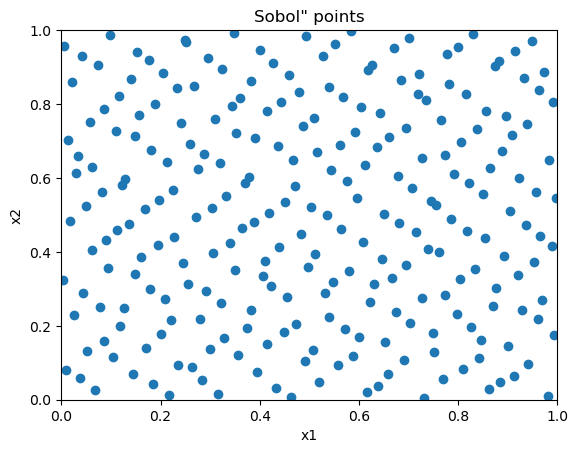

In [4]:
xSobol = qp.DigitalNetB2(d).gen_samples(n)
plt.scatter(xSobol[:, 0], xSobol[:, 1])
plt.title('Sobol" points')
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis([0,1,0,1])
plt.show()

### Pricing the Asian Arithmetic Mean Call Option
Now we set up the parameters for option pricing.  We consider first the Asian Geometric Mean Call with weeky monitoring for three months

In [5]:
initPrice = 100 # initial stock price
interest = 0.02 # risk-free interest rate
vol = 0.5 # volatility
callput = 'call' # call options
strike = 100 # strike price
tfinal = 1/4 # mature time
d = 13 # number of observations
absTol = 0.01 # absolute tolerance of a nickel
relTol = 0 # zero relative tolerance
meanType = 'arithmetic'

The first method that we try is simple IID sampling.

In [6]:
start = time.time()
ArithMeanCall = qp.AsianOption(qp.IIDStdUniform(dimension=d), volatility= vol,start_price= initPrice, 
                               strike_price=strike, interest_rate = interest,t_final=1/4,call_put=callput,mean_type=meanType)
sc = qp.CubMCCLT(ArithMeanCall,absTol)
solution, data = sc.integrate()
end = time.time()

In [7]:
print("The price of the Asian arithmetic mean call option using IID sampling is")
print(f"{solution:.4f}", "+/-", absTol, 
      " and this took", f"{int(data.n_total):,}", "paths  and ", end-start,"seconds.")

The price of the Asian arithmetic mean call option using IID sampling is
5.8553 +/- 0.01  and this took 8,397,596 paths  and  12.672250032424927 seconds.


Note that in this case we know the correct answer, and our IID Monte Carlo gives the correct answer.

Next we try Sobol' sampling and see a big speed up:


In [8]:
start = time.time()
ArithMeanCallSobol = qp.AsianOption(qp.DigitalNetB2(dimension=d ),volatility= vol,start_price= initPrice, 
                               strike_price=strike, interest_rate = interest,t_final=1/4,call_put=callput,mean_type=meanType)
sc = qp.CubQMCSobolG(ArithMeanCallSobol, abs_tol=absTol)
approx_solution, data = sc.integrate()
end = time.time()

In [9]:
print("The price of the Asian arithmetic mean call option using Sobol' sampling is")
print(f"{solution:.4f}", "+/-", absTol, 
      " and this took", f"{int(data.n_total):,}", "paths  and ", end-start,"seconds.")

The price of the Asian arithmetic mean call option using Sobol' sampling is
5.8553 +/- 0.01  and this took 4,096 paths  and  0.30444908142089844 seconds.


Another option is to use lattice sampling.


In [10]:
start = time.time()
ArithMeanCallLattice = qp.AsianOption(qp.Lattice(dimension=d),volatility= vol,start_price= initPrice, 
                               strike_price=strike, interest_rate = interest,t_final=1/4,call_put=callput,mean_type=meanType)
sc = qp.CubQMCLatticeG(ArithMeanCallLattice, abs_tol=absTol)
approx_solution, data = sc.integrate()
end = time.time()

In [11]:
print("The price of the Asian arithmetic mean call option using lattice sampling is")
print(f"{solution:.4f}", "+/-", absTol, 
      " and this took", f"{int(data.n_total):,}", "paths  and ", end-start,"seconds.")

The price of the Asian arithmetic mean call option using lattice sampling is
5.8553 +/- 0.01  and this took 8,192 paths  and  0.04241204261779785 seconds.
